# E-Commerce Recommender System



 ## Load and Preprocess Data



In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/sample_data/data.csv', encoding='latin1')

# Display basic info
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [ ]:
# Basic Information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [ ]:
# Display basic statistics
print(df.describe())

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [ ]:
# Display missing values
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
# Data preprocessing

In [ ]:
df.dropna(subset=['CustomerID'], inplace=True)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df = df[df['Quantity'] > 0]

df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

print("After preprocessing:", df.shape)

After preprocessing: (397924, 10)


## Data Visualization



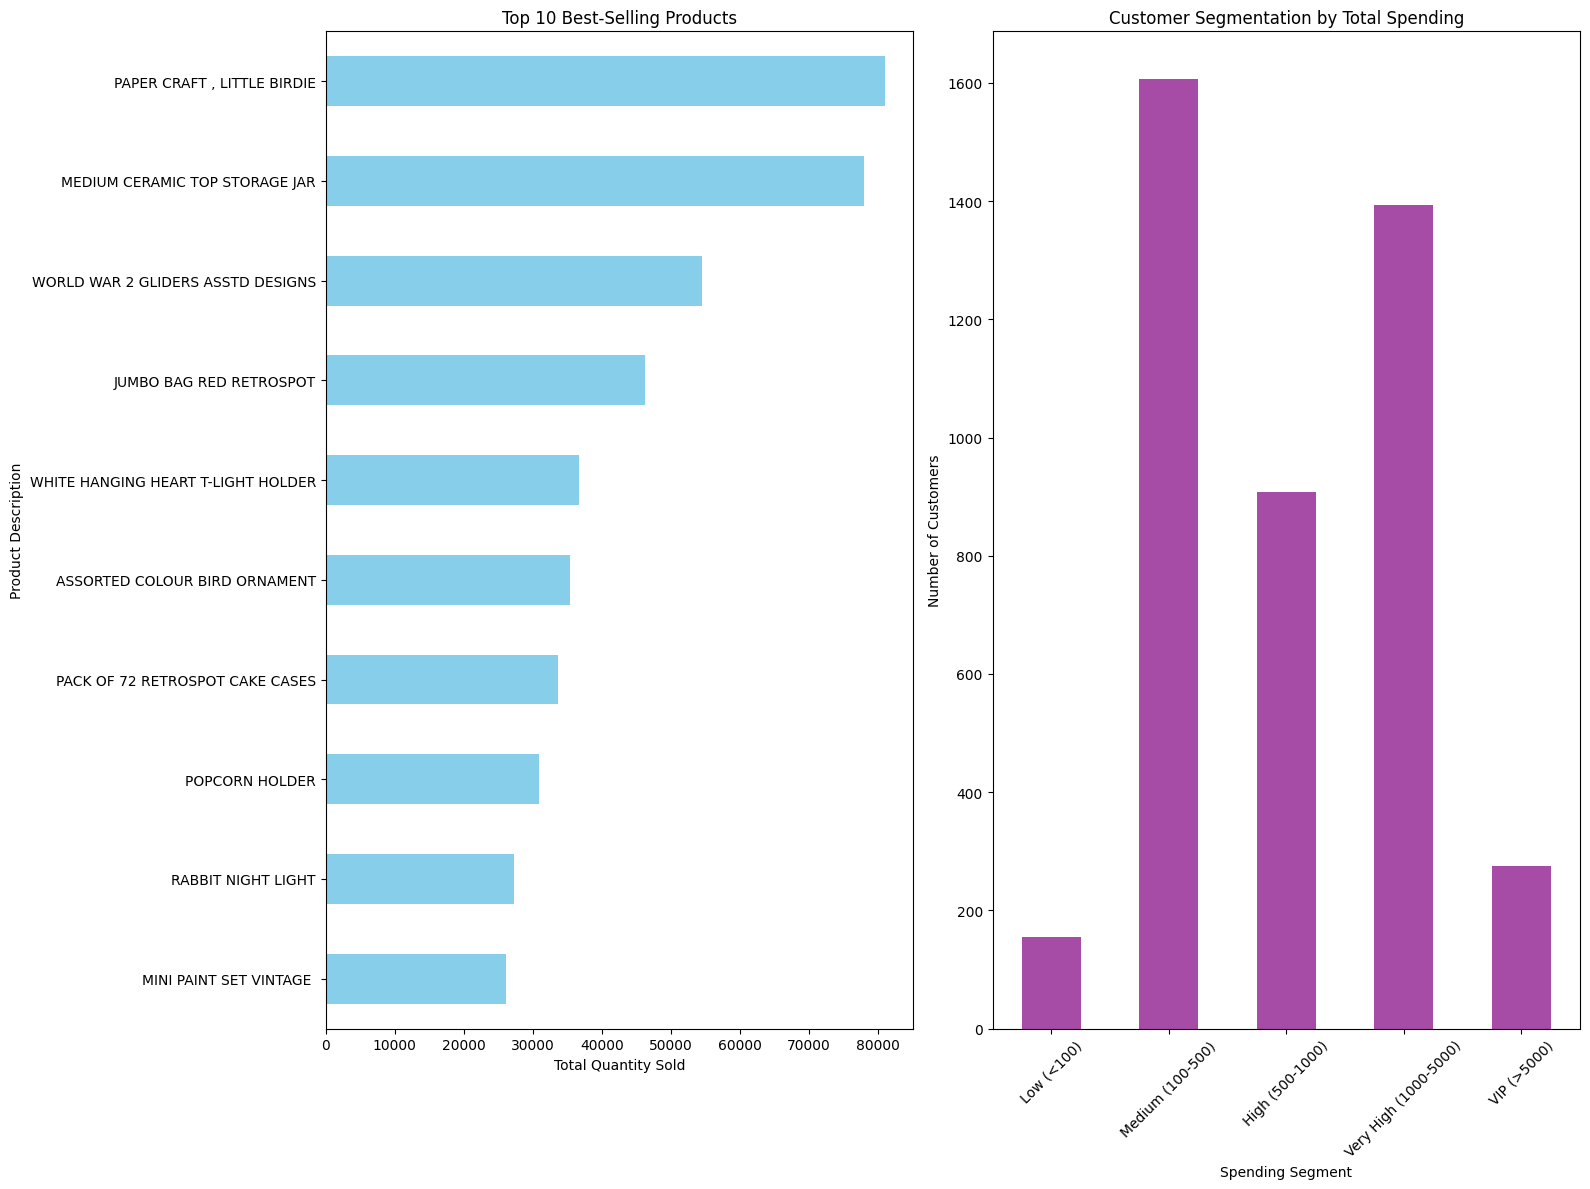

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create user features for segmentation
user_features = df.groupby('CustomerID').agg(
    total_purchases=('InvoiceNo', 'nunique'),
    total_items=('Quantity', 'sum'),
    total_spent=('TotalPrice', 'sum'),
    avg_purchase_value=('TotalPrice', 'mean'),
    purchase_frequency=('InvoiceDate', lambda x: (x.max() - x.min()).days / len(x.unique()) if len(x.unique()) > 1 else 0)
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 12))

# 1. Top 10 Best-Selling Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', color='skyblue', ax=axes[0])
axes[0].set_title('Top 10 Best-Selling Products')
axes[0].set_xlabel('Total Quantity Sold')
axes[0].set_ylabel('Product Description')
axes[0].invert_yaxis()  # Invert y-axis to show highest at top

# 2. Customer Segmentation by Spending
user_features['spending_segment'] = pd.cut(user_features['total_spent'],
                                          bins=[0, 100, 500, 1000, 5000, user_features['total_spent'].max()],
                                          labels=['Low (<100)', 'Medium (100-500)', 'High (500-1000)', 'Very High (1000-5000)', 'VIP (>5000)'])

segment_counts = user_features['spending_segment'].value_counts().sort_index()
segment_counts.plot(kind='bar', color='purple', alpha=0.7, ax=axes[1])
axes[1].set_title('Customer Segmentation by Total Spending')
axes[1].set_xlabel('Spending Segment')
axes[1].set_ylabel('Number of Customers')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sales Distribution by Product Category')

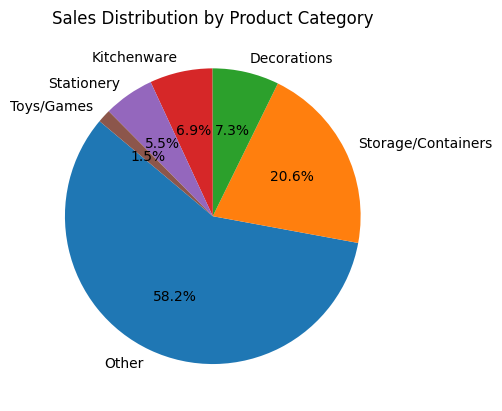

In [ ]:
# Product Categories Analysis (based on Description keywords)
def categorize_product(description):
    desc = description.lower()
    if any(word in desc for word in ['mug', 'cup', 'glass', 'plate', 'bowl']):
        return 'Kitchenware'
    elif any(word in desc for word in ['bag', 'box', 'case', 'holder']):
        return 'Storage/Containers'
    elif any(word in desc for word in ['heart', 'star', 'balloon', 'decoration']):
        return 'Decorations'
    elif any(word in desc for word in ['card', 'paper', 'notebook']):
        return 'Stationery'
    elif any(word in desc for word in ['toy', 'doll', 'game', 'puzzle']):
        return 'Toys/Games'
    else:
        return 'Other'

df['Category'] = df['Description'].apply(categorize_product)
category_sales = df.groupby('Category')['TotalPrice'].sum().sort_values(ascending=False)

plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=140)
plt.title('Sales Distribution by Product Category')

## User-Based Features



In [ ]:
# Group by CustomerID to create user features
user_features = df.groupby('CustomerID').agg(
    total_purchases=('InvoiceNo', 'nunique'),
    total_items=('Quantity', 'sum'),
    total_spent=('TotalPrice', 'sum'),
    avg_purchase_value=('TotalPrice', 'mean'),
    purchase_frequency=('InvoiceDate', lambda x: (x.max() - x.min()).days / len(x.unique()) if len(x.unique()) > 1 else 0),
    recency=('InvoiceDate', lambda x: (df['InvoiceDate'].max() - x.max()).days),
    unique_products=('StockCode', 'nunique')
).reset_index()

print("User features:")
print(user_features.head())


User features:
   CustomerID  total_purchases  total_items  total_spent  avg_purchase_value  \
0     12346.0                1        74215     77183.60        77183.600000   
1     12347.0                7         2458      4310.00           23.681319   
2     12348.0                4         2341      1797.24           57.975484   
3     12349.0                1          631      1757.55           24.076027   
4     12350.0                1          197       334.40           19.670588   

   purchase_frequency  recency  unique_products  
0            0.000000      325                1  
1           52.142857        1              103  
2           70.500000       74               22  
3            0.000000       18               73  
4            0.000000      309               17  


## Aggregation on User Data


In [ ]:
# Aggregate by user and product to get user-item interactions
user_item = df.groupby(['CustomerID', 'StockCode']).agg(
    quantity=('Quantity', 'sum'),
    total_spent=('TotalPrice', 'sum')
).reset_index()

user_item_matrix = user_item.pivot(index='CustomerID', columns='StockCode', values='quantity').fillna(0)

print("User-item matrix shape:", user_item_matrix.shape)
print(user_item_matrix.head())

User-item matrix shape: (4339, 3665)
StockCode   10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
CustomerID                                                                     
12346.0       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
12347.0       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
12348.0       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
12349.0       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
12350.0       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   

StockCode   11001  ...  90214V  90214W  90214Y  90214Z  BANK CHARGES   C2  \
CustomerID         ...                                                      
12346.0       0.0  ...     0.0     0.0     0.0     0.0           0.0  0.0   
12347.0       0.0  ...     0.0     0.0     0.0     0.0           0.0  0.0   
12348.0       0.0  ...     0.0     0.0     0.0     0.0           0.0  0.0   
12349.0       0.0

In [ ]:
# Additional aggregation: User-category interactions
user_category = df.groupby(['CustomerID', 'Category']).agg(
    category_quantity=('Quantity', 'sum'),
    category_spent=('TotalPrice', 'sum')
).reset_index()

print("\nUser-category aggregation:")
print(user_category.head())


User-category aggregation:
   CustomerID     Category  category_quantity  category_spent
0     12346.0        Other              74215         77183.6
1     12347.0  Decorations                150           182.1
2     12347.0  Kitchenware                100           256.6
3     12347.0        Other               1336          2505.6
4     12347.0   Stationery                278           489.3


In [ ]:
# Additional aggregation: User-monthly spending patterns
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

user_monthly = df.groupby(['CustomerID', 'YearMonth']).agg(
    monthly_spent=('TotalPrice', 'sum'),
    monthly_purchases=('InvoiceNo', 'nunique')
).reset_index()

print("\nUser-monthly aggregation:")
print(user_monthly.head())


User-monthly aggregation:
   CustomerID YearMonth  monthly_spent  monthly_purchases
0     12346.0   2011-01       77183.60                  1
1     12347.0   2010-12         711.79                  1
2     12347.0   2011-01         475.39                  1
3     12347.0   2011-04         636.25                  1
4     12347.0   2011-06         382.52                  1


##  Extract Time-Based Trends



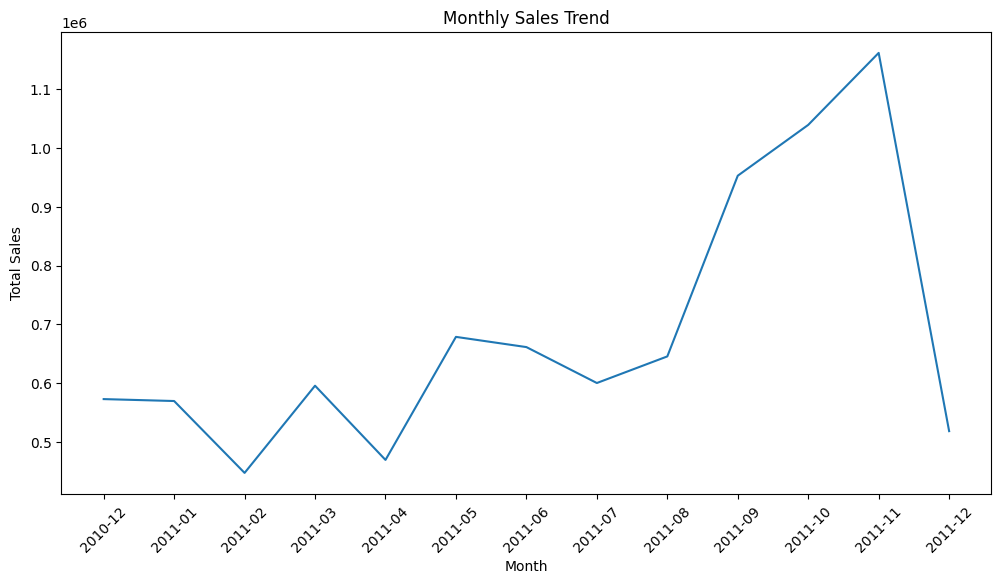

In [ ]:
# Monthly sales trend
monthly_sales = df.groupby('YearMonth').agg(
    total_sales=('TotalPrice', 'sum'),
    num_transactions=('InvoiceNo', 'nunique'),
    num_customers=('CustomerID', 'nunique')
).reset_index()

# Plot monthly sales trend
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['YearMonth'].astype(str), monthly_sales['total_sales'])
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

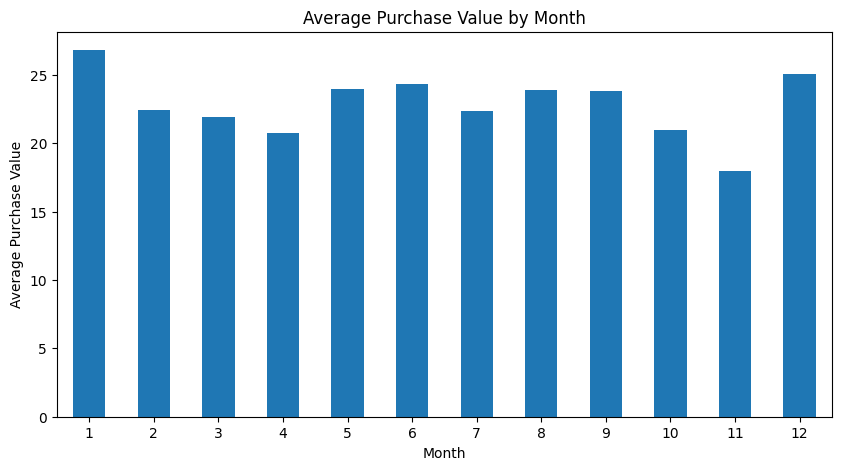

In [ ]:
# Seasonal analysis (by month)
df['Month'] = df['InvoiceDate'].dt.month
monthly_avg = df.groupby('Month')['TotalPrice'].mean()
plt.figure(figsize=(10,5))
monthly_avg.plot(kind='bar')
plt.title('Average Purchase Value by Month')
plt.xlabel('Month')
plt.xticks(rotation=360)
plt.ylabel('Average Purchase Value')
plt.show()

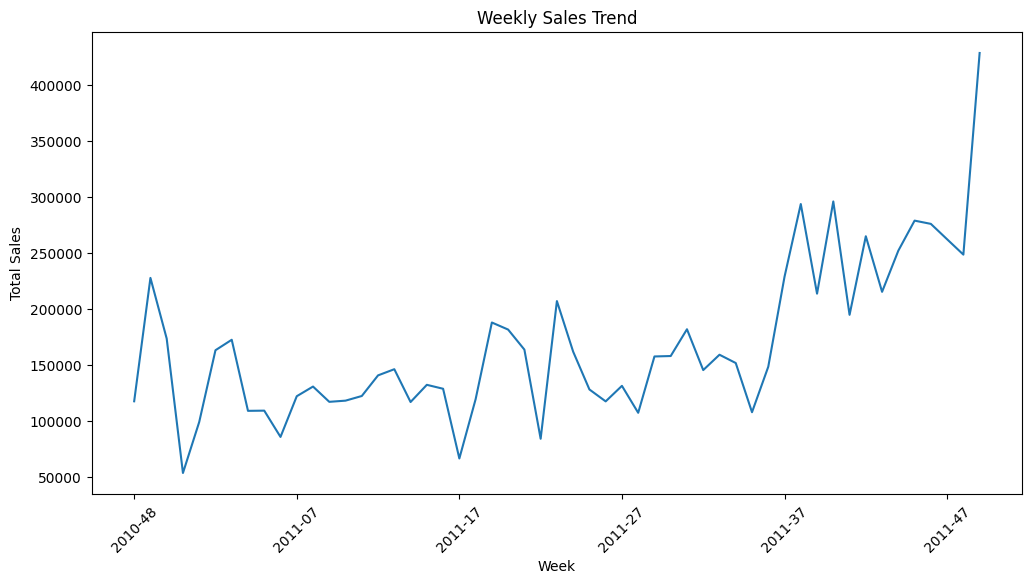

In [ ]:
# Additional time-based trend: Weekly sales
df['WeekOfYear'] = df['InvoiceDate'].dt.strftime('%Y-%U')
weekly_sales = df.groupby('WeekOfYear')['TotalPrice'].sum()
plt.figure(figsize=(12,6))
weekly_sales.plot()
plt.title('Weekly Sales Trend')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

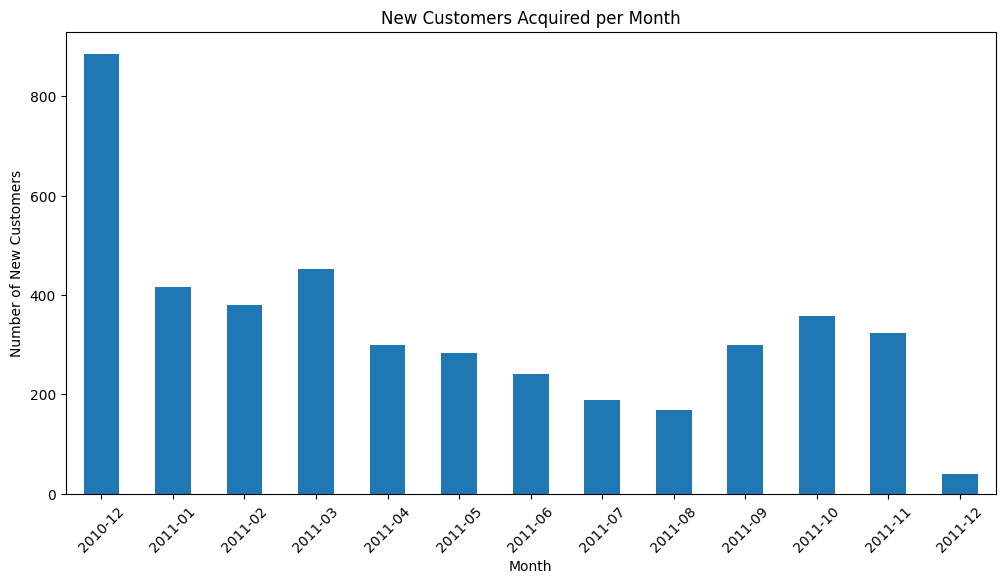

In [ ]:
# time-based trend: Customer acquisition over time
customer_first_purchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
customer_first_purchase['YearMonth'] = customer_first_purchase['InvoiceDate'].dt.to_period('M')
new_customers_per_month = customer_first_purchase.groupby('YearMonth')['CustomerID'].count()
plt.figure(figsize=(12,6))
new_customers_per_month.plot(kind='bar')
plt.title('New Customers Acquired per Month')
plt.xlabel('Month')
plt.ylabel('Number of New Customers')
plt.xticks(rotation=45)
plt.show()

##  Build and Evaluate Recommender Model



In [ ]:
# Model Setup and Training

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

item_descriptions = df.drop_duplicates('StockCode').set_index('StockCode')['Description'].to_dict()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Normalize user-item matrix (L2 normalization)
    user_item_matrix_norm = user_item_matrix.div(np.sqrt(np.square(user_item_matrix).sum(axis=1)), axis=0)

    user_means = user_item_matrix_norm.mean(axis=1)
    user_item_centered = user_item_matrix_norm.sub(user_means, axis=0).fillna(0)

    epsilon = 1e-8
    user_similarity = cosine_similarity(user_item_centered) + epsilon

user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Function to get recommendations for a user
def get_recommendations(customer_id, num_recommendations=5):
    if customer_id not in user_similarity_df.index:
        return []

    # Get most similar users
    similar_users = user_similarity_df[customer_id].sort_values(ascending=False).iloc[1:num_recommendations+1]

    recommendations = {}
    for sim_user in similar_users.index:
        user_purchases = user_item_matrix.loc[sim_user]
        for item in user_purchases[user_purchases > 0].index:
            if user_item_matrix.loc[customer_id, item] == 0:  # User hasn't purchased this item
                if item not in recommendations:
                    recommendations[item] = 0
                recommendations[item] += similar_users[sim_user] * user_purchases[item]


    return sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]

In [ ]:
# Examples and Evaluation

In [ ]:
# Example: Try customer with ID 2
test_customer = user_item_matrix.index[1]
if test_customer in user_item_matrix.index:
    recommendations_test = get_recommendations(test_customer, 5)
    print(f"Recommendations for customer {test_customer}:")
    for item, score in recommendations_test:
        description = item_descriptions.get(item, 'Unknown Item')
        print(f"  Item {item} ({description}): {score:.2f}")
else:
    print(f"Customer {test_customer} not found in the dataset. Valid customer IDs start from {user_item_matrix.index[0]}")

# Split data into train and test sets
train_data, test_data = train_test_split(user_item_matrix, test_size=0.2, random_state=42)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_norm = train_data.div(np.sqrt(np.square(train_data).sum(axis=1)), axis=0)
    train_means = train_norm.mean(axis=1)
    train_centered = train_norm.sub(train_means, axis=0).fillna(0)

    train_similarity = cosine_similarity(train_centered) + epsilon

train_similarity_df = pd.DataFrame(train_similarity, index=train_data.index, columns=train_data.index)

# Predict ratings for test users
def predict_rating(user, item):
    if user not in train_similarity_df.index or item not in train_data.columns:
        return 0
    similar_users = train_similarity_df[user].sort_values(ascending=False).iloc[1:6]  # Top 5 similar
    numerator = 0
    denominator = 0
    for sim_user, sim_score in similar_users.items():
        if not pd.isna(train_data.loc[sim_user, item]):
            numerator += sim_score * train_data.loc[sim_user, item]
            denominator += sim_score
    return numerator / (denominator + epsilon) if denominator != 0 else 0

test_predictions = []
test_actuals = []
for user in test_data.index[:10]:  # Sample for speed
    for item in test_data.columns:
        if test_data.loc[user, item] > 0:
            pred = predict_rating(user, item)
            test_predictions.append(pred)
            test_actuals.append(test_data.loc[user, item])

if test_predictions:
    rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
    print(f"\nRMSE on test set: {rmse:.2f}")
else:
    print("No test predictions to evaluate.")

Recommendations for customer 12347.0:
  Item 23077 (DOUGHNUT LIP GLOSS ): 38.84
  Item 22418 (10 COLOUR SPACEBOY PEN): 37.88
  Item 22693 (GROW A FLYTRAP OR SUNFLOWER IN TIN): 37.39
  Item 22614 (PACK OF 12 SPACEBOY TISSUES): 33.02
  Item 22065 (CHRISTMAS PUDDING TRINKET POT ): 25.38

RMSE on test set: 32.12


In [ ]:

# Example 1: First customer
example_customer = user_item_matrix.index[0]
recommendations = get_recommendations(example_customer, 5)
print(f"\nRecommendations for customer {example_customer}:")
for item, score in recommendations:
    description = item_descriptions.get(item, 'Unknown Item')
    print(f"  Item {item} ({description}): {score:.2f}")


Recommendations for customer 12346.0:
  Item 23167 (SMALL CERAMIC TOP STORAGE JAR ): 40.55
  Item 21400 (RED PUDDING SPOON): 38.74
  Item 21401 (BLUE PUDDING SPOON): 38.74
  Item 22962 (JAM JAR WITH PINK LID): 27.66
  Item 47566 (PARTY BUNTING): 23.82


In [ ]:
# Example 3: Get recommendations for a specific customer ID
specific_customer = 17850.0
if specific_customer in user_item_matrix.index:
    recommendations3 = get_recommendations(specific_customer, 5)
    print(f"\nRecommendations for customer {specific_customer}:")
    for item, score in recommendations3:
        description = item_descriptions.get(item, 'Unknown Item')
        print(f"  Item {item} ({description}): {score:.2f}")
else:
    print(f"\nCustomer {specific_customer} not found in the dataset.")


Recommendations for customer 17850.0:
  Item 21733 (RED HANGING HEART T-LIGHT HOLDER): 34.16
  Item 22789 (T-LIGHT HOLDER SWEETHEART HANGING): 17.55
  Item 84077 (WORLD WAR 2 GLIDERS ASSTD DESIGNS): 17.23
  Item 21754 (HOME BUILDING BLOCK WORD): 15.62
  Item 23327 (HANGING CLEAR MINI BOTTLE): 14.92
